In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
d = pd.read_csv('../data/annotation/phastConsElements100way.txt.gz', sep='\t', names=('chr', 'start', 'end', 'lod', 'score'))
d['score'] = d['score'] / 1000

In [11]:
d

,chr,start,end,lod,score
585,chr1,12007,12020,lod=48,0.377
585,chr1,12021,12035,lod=37,0.351
585,chr1,12039,12050,lod=23,0.304
585,chr1,12065,12085,lod=30,0.330
585,chr1,12176,12194,lod=175,0.505
...,...,...,...,...,...
1021,chrY,57213597,57213607,lod=43,0.366
1021,chrY,57213873,57213967,lod=511,0.611
1021,chrY,57214343,57214417,lod=370,0.579
1021,chrY,57214535,57214569,lod=31,0.333


In [13]:
score = d['score'].values

(array([2.768023e+06, 4.293343e+06, 1.708206e+06, 9.520130e+05,
        4.329850e+05, 1.452590e+05, 3.922800e+04, 9.817000e+03,
        1.784000e+03, 7.100000e+01]),
 array([0.186 , 0.2674, 0.3488, 0.4302, 0.5116, 0.593 , 0.6744, 0.7558,
        0.8372, 0.9186, 1.    ]),
 <BarContainer object of 10 artists>)

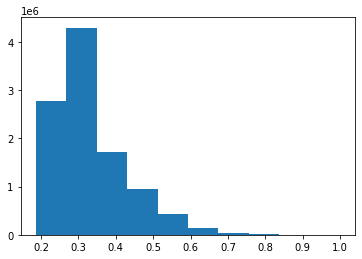

In [14]:
plt.hist(score)

In [19]:
q = np.quantile(score, 0.95)
q

0.526

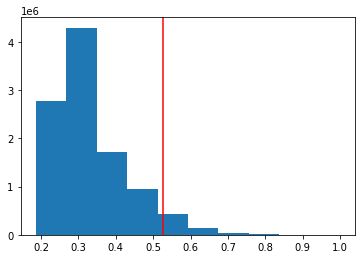

In [21]:
plt.hist(score)
plt.axvline(q, c='r')